In [24]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
sns.set_style("darkgrid")

# Numerical Setup

In [169]:
N = 50
M = 20 # Number of measurements 
K = 5 # Number of non-zero  coefficents 
T = 50 # Number of time-steps
sparse_support = np.random.choice(N, K, replace=False) # s locations chosen uniformly at random
A = np.random.normal(0, 1, (M, N)) # measurement matrix

# Time Varying Sparse Support

In [481]:
# Signal Helpers
def get_spikes(K=K):
    return (-1)**np.random.randint(2, size=K)

def get_perturbations(supp=sparse_support, N=N):
    pert_vec = np.zeros(N)
    pert_vec[supp] = np.random.normal(0, (0.1)**2, len(supp))
    return pert_vec

def get_new_entries(K=K, N=N):
    K_n = np.random.randint(0, np.ceil(K/20.)+1) # same setup as example paper
    supp = np.random.choice(N, K_n)
    new_vec = np.zeros(N)
    new_vec[supp] = np.random.normal(0, 1, K_n)
    return supp, new_vec

# Measurement Helpers
def get_noise(M=M):
    return np.random.normal(0, (0.01)**2, (M,1))

def get_measurment_matrix(M=M, N=N):
    return np.random.normal(0, 1./M, (M, N)) # measurement matrix

In [486]:
def get_next_X(X, supp):
    pert_vec = get_perturbations(supp)
    new_supp, new_vec = get_new_entries()
    next_X = X + pert_vec + new_vec
    next_supp = list(set(supp).union(set(new_supp)))
    return next_X, next_supp

In [496]:
X = get_X()

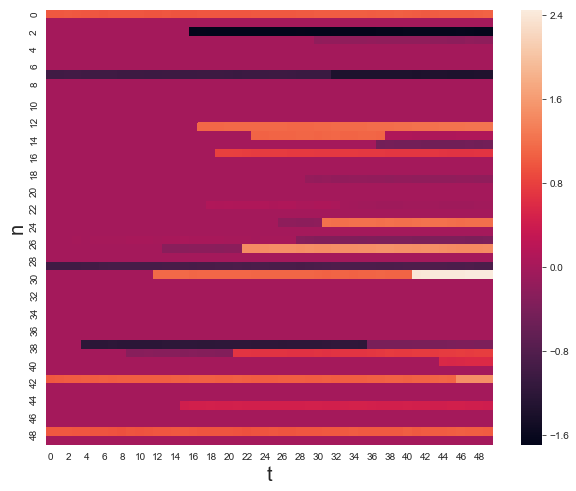

In [504]:
ax = sns.heatmap(X)
ax.set_xlabel('t', fontsize=20)
ax.set_ylabel('n', fontsize=20)
plt.savefig('time_varying.pdf')

# Time-Independent Numerical Setup

In [139]:
X_jointsupp = np.zeros((N, T))
X_jointsupp[sparse_support,:] = np.random.normal(0, 1, (K,T))
Y_jointsupp = A.dot(X_jointsupp)
max_iter = 5*T

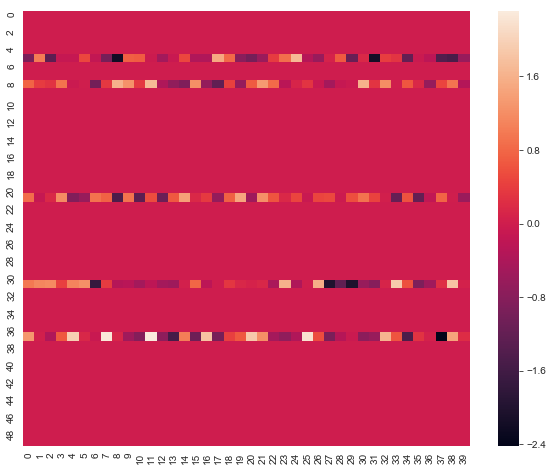

In [93]:
sns.heatmap(X_jointsupp)

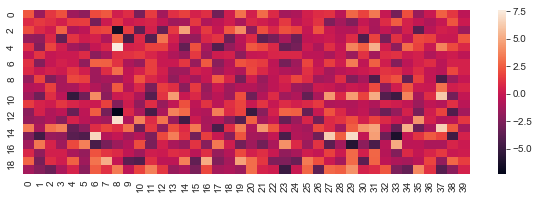

In [95]:
plt.figure(figsize=(10, 3))
sns.heatmap(Y_jointsupp)

# Temporal Correlation Numerical Setup

In [170]:
def get_x_t(t, D_coeffs, z_coeffs, x_0_coeffs):
    if t == 0:
        return x_0_coeffs
    else: 
        return  D_coeffs*get_x_t(t-1, D_coeffs, z_coeffs, x_0_coeffs) + z_coeffs[t]
# Generated via the AR process
def get_x(T, sparse_support):
    K=len(sparse_support)
    x_0_coeffs = sp.random.normal(0, 1, K) 
    D_coeffs = sp.random.uniform(0.8, 1.0, K) # Correlation matrix with diagnonal entries chosen uniformly from [0.8, 1]
    z_coeffs = sp.random.normal(0, (1-D_coeffs**2)[1], (T, K))
    x=[sp.sparse.csr_matrix((get_x_t(t, D_coeffs, z_coeffs, x_0_coeffs), (
        sparse_support, sp.zeros(K))), shape=(N,1)) for t in range(T)]
    return sp.sparse.hstack(x), D_coeffs, z_coeffs

In [171]:
def get_y(x, A, noise=0):    
    return sp.hstack([A*x.tocsc()[:,t] + noise for t in range(x.shape[1])])

In [489]:
def get_X(N=N, T=T, init_supp=sparse_support):
    X = np.zeros((N, T))
    X[init_supp, 0] = get_spikes(len(init_supp))
    supp = init_supp
    for t in np.arange(1,N,1):
        X[:, t], supp = get_next_X(X[:, t-1], supp)
    return X

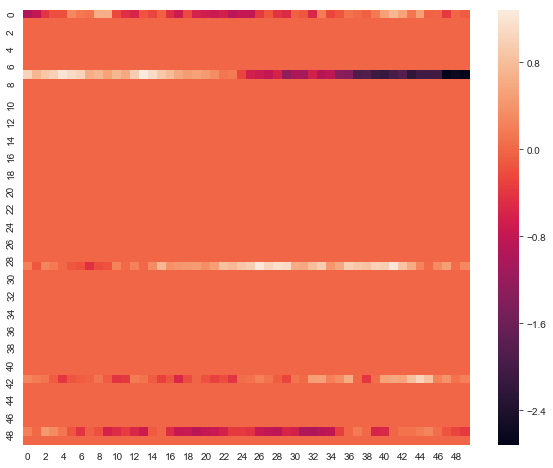

In [172]:
X_tempcorr, D_coeffs, z_coeffs = get_x(T, sparse_support)
sns.heatmap(X_tempcorr.todense())

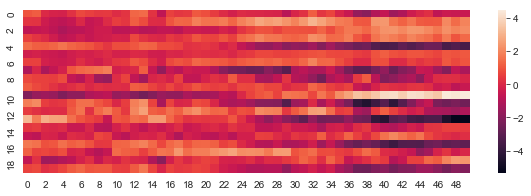

In [173]:
plt.figure(figsize=(10, 3))
Y_tempcorr = get_y(X_tempcorr, A)
sns.heatmap(Y_tempcorr)